In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

COVID = pd.read_excel('../owid-covid-data-ko.xlsx')
COVID = COVID.fillna(0)
COVID.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,KOR,Asia,South Korea,2020-01-22,1,0.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,0.0,0.00,0.00,0.000000
1,KOR,Asia,South Korea,2020-01-23,1,0.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,0.0,0.00,0.00,0.000000
2,KOR,Asia,South Korea,2020-01-24,2,1.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,0.0,0.00,0.00,0.000000
3,KOR,Asia,South Korea,2020-01-25,2,0.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,0.0,0.00,0.00,0.000000
4,KOR,Asia,South Korea,2020-01-26,3,1.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,43.4,0.17,2.47,0.845918


In [42]:
X = COVID[['new_cases_smoothed', 'new_deaths_smoothed', 'icu_patients',
'total_vaccinations', 'total_boosters', 'new_vaccinations_smoothed',
       'stringency_index']]
y = COVID['new_deaths']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [44]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [45]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

In [46]:
print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  17.568725227325558
RMSE of Test Data:  17.601368965812792


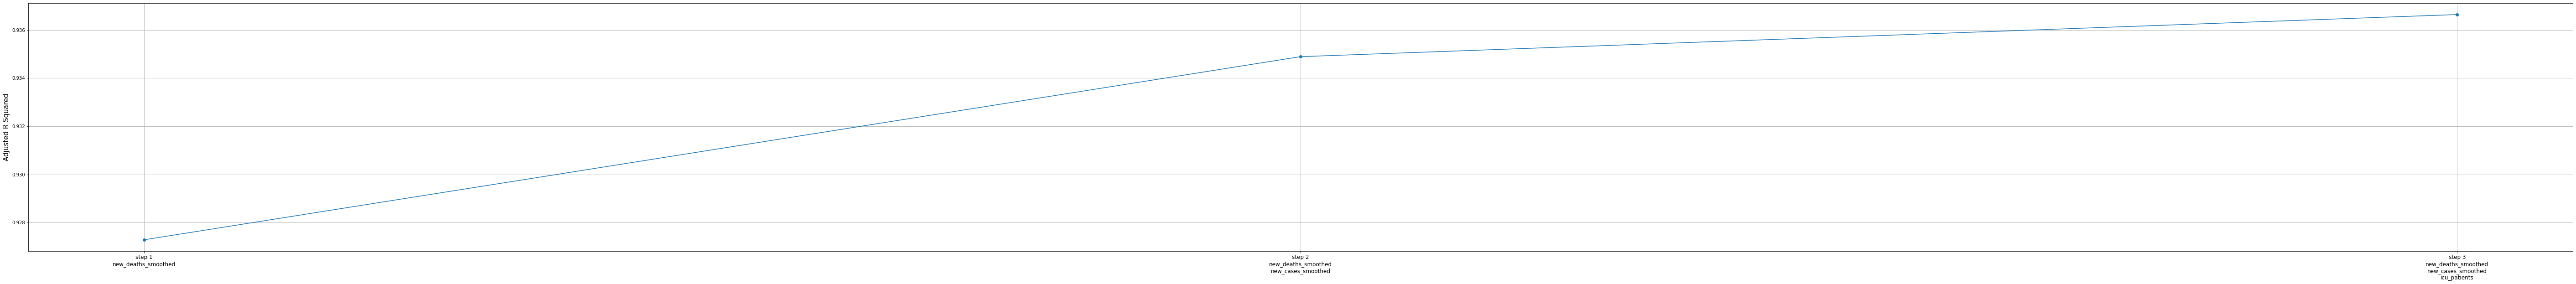

In [47]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [48]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     3297.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        00:46:22   Log-Likelihood:                -2872.6
No. Observations:                 670   AIC:                             5753.
Df Residuals:                     666   BIC:                             5771.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9852    

In [49]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 1.

In [50]:
y, X = dmatrices('new_deaths ~new_deaths_smoothed+new_cases_smoothed+icu_patients', COVID, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,2.010101,Intercept
1,10.912907,new_deaths_smoothed
2,7.375711,new_cases_smoothed
3,2.947232,icu_patients


---

In [51]:
['total_cases', 'new_cases', 'reproduction_rate', 'hosp_patients', 'icu_patients', 'positive_rate', 'weekly_icu_admissions', 'weekly_hosp_admissions', 'total_tests', 'new_tests', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'stringency_index']

['total_cases',
 'new_cases',
 'reproduction_rate',
 'hosp_patients',
 'icu_patients',
 'positive_rate',
 'weekly_icu_admissions',
 'weekly_hosp_admissions',
 'total_tests',
 'new_tests',
 'positive_rate',
 'tests_per_case',
 'total_vaccinations',
 'stringency_index']

In [52]:
[['new_cases_smoothed', 'new_deaths_smoothed', 'total_boosters', 'new_vaccinations_smoothed',
       ]]

[['new_cases_smoothed',
  'new_deaths_smoothed',
  'total_boosters',
  'new_vaccinations_smoothed']]

In [53]:
X = COVID[['total_cases', 'new_cases', 'reproduction_rate', 'icu_patients', 'positive_rate', 'weekly_icu_admissions', 'weekly_hosp_admissions', 'total_tests', 'new_tests', 'tests_per_case', 'total_vaccinations', 'stringency_index' ]]
y = COVID[['new_deaths']]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [55]:
X_train

,total_cases,new_cases,reproduction_rate,icu_patients,positive_rate,weekly_icu_admissions,weekly_hosp_admissions,total_tests,new_tests,tests_per_case,total_vaccinations,stringency_index
206,15318,279.0,3.11,14.0,0.0131,0.0,0.0,1673944.0,10212.0,76.1,0.0,53.24
677,447230,3030.0,1.20,629.0,0.0000,0.0,4543.0,0.0,0.0,0.0,85371460.0,40.28
819,16674045,90825.0,0.59,808.0,0.4814,0.0,6242.0,43612398.0,203803.0,2.1,121685966.0,16.67
737,811122,17540.0,1.79,316.0,0.0000,0.0,5887.0,0.0,0.0,0.0,114126148.0,50.93
682,473034,5127.0,1.28,752.0,0.0000,530.0,4716.0,0.0,0.0,0.0,86739919.0,40.28
...,...,...,...,...,...,...,...,...,...,...,...,...
742,907214,22904.0,1.58,278.0,0.0000,0.0,7328.0,0.0,0.0,0.0,114562601.0,50.93
528,160084,742.0,1.23,144.0,0.0000,0.0,0.0,0.0,0.0,0.0,19789650.0,36.57
74,10237,81.0,0.73,81.0,0.0097,0.0,0.0,459881.0,6201.0,102.6,0.0,78.70
176,13672,60.0,1.02,16.0,0.0048,0.0,0.0,1439996.0,10032.0,208.3,0.0,53.24


In [56]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [57]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  19.42546232834527
RMSE of Test Data:  18.96837731147268


In [58]:
print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  19.42546232834527
RMSE of Test Data:  18.96837731147268


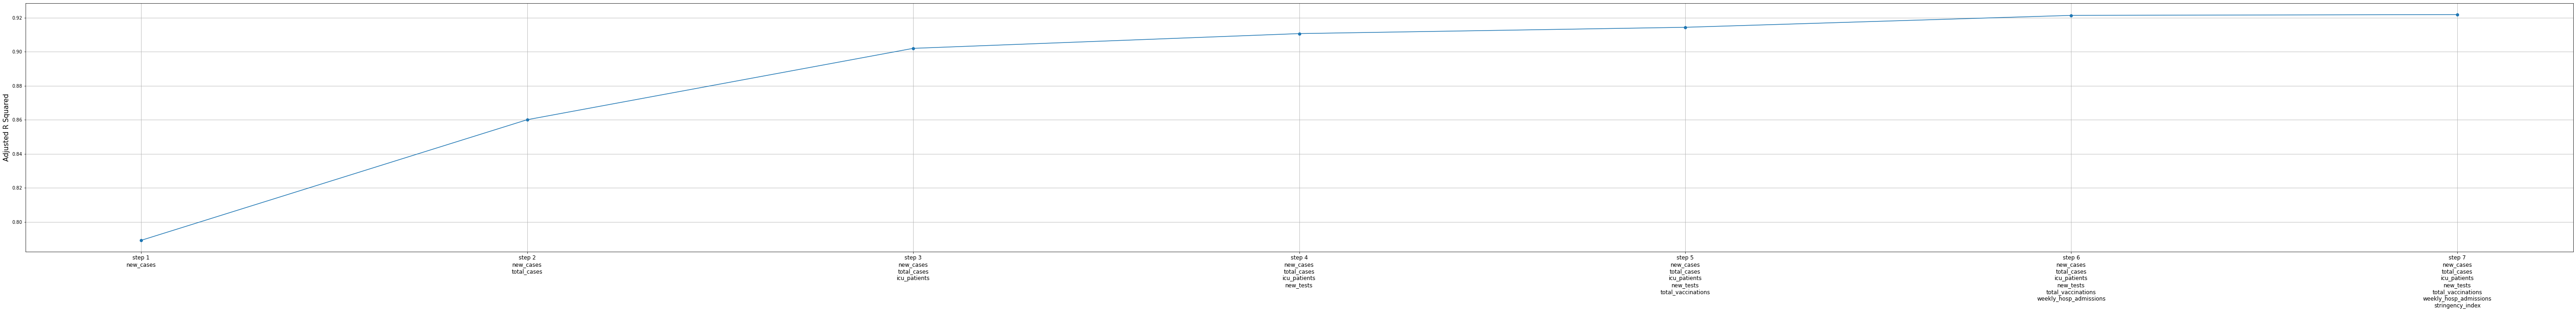

In [59]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [60]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1128.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        00:46:24   Log-Likelihood:                -2941.0
No. Observations:                 670   AIC:                             5898.
Df Residuals:                     662   BIC:                             5934.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -11

# 2.

In [61]:
y, X = dmatrices('new_deaths ~total_cases+ new_cases+icu_patients+weekly_hosp_admissions+ new_tests+total_vaccinations+ stringency_index', COVID, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,29.448269,Intercept
1,2.273734,total_cases
2,6.945069,new_cases
3,4.821977,icu_patients
4,9.811374,weekly_hosp_admissions
5,6.059175,new_tests
6,6.306728,total_vaccinations
7,1.563315,stringency_index


In [62]:
X = COVID[['new_cases', 'reproduction_rate', 'icu_patients', 'positive_rate', 'weekly_icu_admissions', 'weekly_hosp_admissions', 'total_tests', 'new_tests', 'tests_per_case', 'total_vaccinations', 'stringency_index', 'new_cases_smoothed', 'new_deaths_smoothed', 'total_boosters', 'new_vaccinations_smoothed' ]]
y = COVID[['new_deaths']]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [64]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [65]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  15.869653016863259
RMSE of Test Data:  19.6910396538815


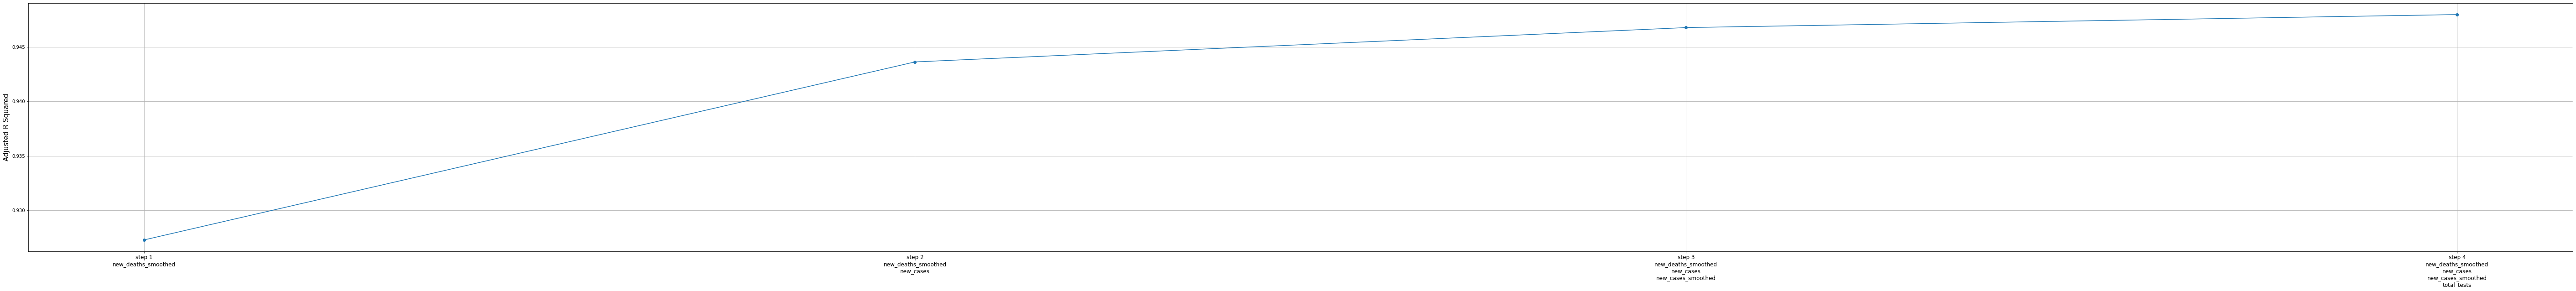

In [66]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [67]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     3048.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        00:46:25   Log-Likelihood:                -2806.2
No. Observations:                 670   AIC:                             5622.
Df Residuals:                     665   BIC:                             5645.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1825    

# 3

In [68]:
y, X = dmatrices('new_deaths ~new_deaths_smoothed+new_cases+new_cases_smoothed+total_tests', COVID, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,1.247960,Intercept
1,11.652076,new_deaths_smoothed
2,17.854996,new_cases
3,32.399130,new_cases_smoothed
4,4.203061,total_tests


---

In [ ]:
## 실제 예측값과 비교 및 시각화 